# Setup

Force Sensor

In [3]:
import nidaqmx 
import atiiaftt as ati
from nidaqmx.stream_readers import AnalogMultiChannelReader
import time as Time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ftsensor
import datetime as dt
import csv
import serial
from time import sleep

sensor = ftsensor.ftsensor(tool_offset=[0,0,52,0,0,0])

ENTER = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFC])
EXIT = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFD])
ZERO = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFE])


# AK70-10 24V Motor Limit
P_MIN = -12.5
P_MAX = 12.5
V_MIN = -50  
V_MAX = 50
T_MIN = -25 
T_MAX = 25
KP_MIN = 0
KP_MAX = 500
KD_MIN = 0
KD_MAX = 5

def unpack(data):
    id = data[0]
    pos = ((data[1]*(P_MAX-P_MIN))/(pow(2,16)-1)) + P_MIN
    vel = ((data[2]*(V_MAX-V_MIN))/(pow(2,12)-1)) + V_MIN
    tor = ((data[3]*(T_MAX-T_MIN))/(pow(2,12)-1)) + T_MIN
    return id, pos, vel, tor

def receive():
    global dT, q1_old, q2_old
    # Read the response from the serial port
    received = ser.readline().decode().split()      

    # Print the received bytes
    # print("Received:", received)

    try:
        test = int(received[0])
        response = [int(x) for x in received]
        [id, p, v, t] = unpack(response)

        if id == 1:
            p = -round(p,3)
            t = -t
            if dT == 0:
                v = 0
            else:
                v = round((p - q1_old)/dT,2)
        
        else:
            p = round(p,3)
            t = t
            if dT == 0:
                v = 0
            else:
                v = round((p-q2_old)/dT,2)

        # print the response from the Arduino
        # print([id, p, v, t])

    except (IndexError, ValueError):
        id = None
        p = 0
        v = 0
        t = 0
    return id, p, v, t

def pack_cmd(p_des, v_des, t_ff, kp, kd):
    bufs = []
    def float_to_uint(val, val_min, val_max, bits):
        val_norm = (val - val_min) / (val_max - val_min)
        val_int = int(round(val_norm * ((1 << bits) - 1)))
        return val_int
    
    p_int = float_to_uint(p_des, P_MIN, P_MAX, 16)
    v_int = float_to_uint(v_des, V_MIN, V_MAX, 12)
    t_int = float_to_uint(t_ff, T_MIN, T_MAX, 12)
    kp_int = float_to_uint(kp, KP_MIN, KP_MAX, 12)
    kd_int = float_to_uint(kd, KD_MIN, KD_MAX, 12)
    
    bufs.append((p_int >> 8) & 0xFF)
    bufs.append(p_int & 0xFF)
    bufs.append((v_int >> 4) & 0xFF)
    bufs.append(((v_int & 0xF) << 4) | ((kp_int >> 8) & 0xF))
    bufs.append(kp_int & 0xFF)
    bufs.append((kd_int >> 4) & 0xFF)
    bufs.append(((kd_int & 0xF) << 4) | ((t_int >> 8) & 0xF))
    bufs.append(t_int & 0xFF)

    return bufs

Construct Serial Connection

In [9]:
# open the serial port
ser = serial.Serial('COM4', 115200, timeout=1)


# Set Zero

In [10]:
print("Begining")


q1_old = 0
pos2_old = 0
dT = 0

#M1
print("Starting Zero Position M1")
ser.write(bytes([0x01])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x01])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()



#M2
print("Starting Zero Position M2")
ser.write(bytes([0x02])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x02])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()

print("Finishing Zero Position")


Begining
Starting Zero Position M1
Starting Zero Position M2
Finishing Zero Position


# Enter Motor and Re-bias Force Sensor

In [12]:
##Motor

dT = 0

#M1
print("Starting Enter Motors")
ser.write(bytes([0x01])+ENTER)
[id, p, v, t] = receive()
if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

#M2
ser.write(bytes([0x02])+ENTER)
[id, p, v, t] = receive()

if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

q1_old = q1
q2_old = q2


##Sensor
sensor.start_task()
current_time = Time.time()
duration = 1
values = []
while Time.time()< current_time + duration:
    values.append(np.array(sensor.read_avg_voltage()))

values = np.array(values)
values = [ft.mean() for ft in values.transpose()]
sensor.set_bias(values)
sensor.stop_task()
print(values)

Starting Enter Motors
[-0.2636218275990135, -0.08320197571359252, 0.19189498443952366, -0.12839513435101513, 0.09267954186876246, -0.128925005523293]


Running

In [13]:
def record_session(T1, T2):
    start_time = dt.datetime.today().timestamp()
    t = 0
    l1 = 0.275
    l2 = 0.24

    logs = list()
    motor_logs = list()
    readings = list()

    t_mapping = 1/1.35

    x = l1*np.sin(q1) + l2*np.cos(q2)
    y = l1*np.cos(q1) - l2*np.sin(q2)

    time = 0
    record_duration = 20

    print("Start Controling")
    sensor.start_task()
    while time < record_duration:
        start_time = dt.datetime.today().timestamp()

        log = list()
        log.append(time)

        q1_old = q1
        q2_old = q2

        x_old = x
        y_old = y
        
        log.append(T1)
        log.append(T2)

        command1 = bytes(pack_cmd(0,0,-T1*t_mapping,0,0)) #(pos,vel,torque,kp,kd)
        command2 = bytes(pack_cmd(0,0,T2*t_mapping,0,0)) #(pos,vel,torque,kp,kd)

        #M1
        ser.write(bytes([0x01])+command1)
        [id, p, v, t] = receive()

        if id == 1:
            q1 = p
            vel1 = v
            t1 = t/t_mapping
        
        elif id == 2:
            q2 = p
            vel2 = v
            t2 = t/t_mapping

        #M2
        ser.write(bytes([0x02])+command2)
        [id, p, v, t] = receive()

        if id == 1:
            q1 = p
            vel1 = v
            t1 = t/t_mapping
        
        elif id == 2:
            q2 = p
            vel2 = v
            t2 = t/t_mapping

        log.append(t1)
        log.append(t2)

        log.append(q1)
        log.append(q2)

        # print("q1: ",q1, "\tq2: ", q2)

        x = l1*np.sin(q1) + l2*np.cos(q2)
        y = l1*np.cos(q1) - l2*np.sin(q2)

        log.append(x)
        log.append(y)

        print("x: ",x, "\ty: ", y)

        if time!= 0:
            x_dot = (x-x_old)/dT
            y_dot = (y-y_old)/dT
        
        else:
            x_dot = 0
            y_dot = 0

        log.append(x_dot)
        log.append(y_dot)

        #Estimate CF
    
        Fx = (t1*l2*np.cos(q2)-t2*l1*np.sin(q1))/(l1*l2*np.cos(q1-q2))
        Fy = (-t1*l2*np.sin(q2)-t2*l1*np.cos(q1))/(l1*l2*np.cos(q1-q2)) 

        log.append(Fx)
        log.append(Fy)

        motor_logs.append(log)

        #Sensor
        reading = sensor.read_ft()
    
        #print(reading)
        
        readings.append(reading)

        log.append(reading[0])
        log.append(reading[1])

        logs.append(log)
        
        # print("Progress", f'{round(time/record_duration*100,3)}%')
        dT = dt.datetime.today().timestamp()-start_time
        time+= dT

    ser.write(bytes([0x01])+EXIT)
    receive()

    #M2
    ser.write(bytes([0x02])+EXIT)
    receive()
        
    sensor.stop_task()

    print("finish")
    return log


Start Controling
x:  0.34042100718279555 	y:  0.25119051300341033
x:  0.3409374659927665 	y:  0.25122901750743576
x:  0.3422411810265887 	y:  0.2524007130995779
x:  0.3432614828129218 	y:  0.25198963810462816
x:  0.34300656164703797 	y:  0.2520927894152467
x:  0.3435163007000517 	y:  0.25188623192446186
x:  0.3442801321412566 	y:  0.25157448520201187
x:  0.3442801321412566 	y:  0.25157448520201187
x:  0.34478883203939475 	y:  0.25136538160854477
x:  0.3452971127132254 	y:  0.25115526103416663
x:  0.3460587432314007 	y:  0.25083817517305734
x:  0.3463151681962112 	y:  0.25097195642884573
x:  0.3470841641588889 	y:  0.2516117870707598
x:  0.3475887332048012 	y:  0.25115710730186697
x:  0.34759053318785127 	y:  0.2513971005418989
x:  0.3480964718313045 	y:  0.2511814017050281
x:  0.3496116852197263 	y:  0.2505282399945328
x:  0.3498638385951881 	y:  0.25041849634350405
x:  0.3498638385951881 	y:  0.25041849634350405
x:  0.3501158821009405 	y:  0.2503085005940137
x:  0.35011876208318055 	y

In [ ]:
logs = record_session(0,0)

# Emergency Exit

In [26]:
ser.write(bytes([0x01])+EXIT)
receive()

#M2
ser.write(bytes([0x02])+EXIT)
receive()


(2, -0.0, 0, 0.006105006105006083)

# Data visualize

In [450]:
df_log.to_csv(f"Joey/Y022/T{T1}{T2}.csv")

In [14]:
##readings

print("Data Sample Size", len(readings))
COLUMNS = ["Force X", "Force Y", "Force Z", "Torque X", "Torque Y", "Torque Z"]
readings
arrays = np.array([np.array(item) for item in readings])

arrays_transpose = arrays.transpose()
df = pd.DataFrame([])
for i in range(len(COLUMNS)):
    df[COLUMNS[i]] = arrays_transpose[i]

print(df)


##logs
print(logs)
logs_COLUMNS = ["Time", "T1", "T2", "t1", "t2", "q1", "q2", "x", "y", "x_dot", "y_dot", "Fx", "Fy", "Fx_Mea", "Fy_Mea"]

logs_arrays = np.array([np.array(item) for item in logs])

logs_arrays_transpose = logs_arrays.transpose()
df_log = pd.DataFrame([])
for i in range(len(logs_COLUMNS)):
    df_log[logs_COLUMNS[i]] = logs_arrays_transpose[i]

print(df_log)

Data Sample Size 1279
       Force X   Force Y   Force Z  Torque X  Torque Y  Torque Z
0     2.078132 -0.715549 -0.031055  0.001215 -0.037982 -0.000175
1     2.254758  0.224893  0.068780  0.015180 -0.058684  0.000358
2     1.157836  0.028862  0.036844  0.003612 -0.017835  0.000520
3     2.828822  0.131397  0.205721  0.008986 -0.067259  0.000470
4     3.190812  0.185123  0.109011  0.016797 -0.059193  0.000485
...        ...       ...       ...       ...       ...       ...
1274  2.439340  1.799061  0.025034  0.038962 -0.035762  0.001218
1275  3.036843  2.195727  0.266002  0.034447 -0.077656  0.001903
1276  4.451713  2.561097  0.000962  0.060064 -0.058272  0.001478
1277  3.507220  2.637619  0.078856  0.057510 -0.063072  0.002028
1278  1.257935  0.712528  0.095907  0.011631 -0.046207  0.001036

[1279 rows x 6 columns]
[[0, 0, 0, -0.008241758241758212, -0.008241758241758212, 0.374, 0.02, 0.34042100718279555, 0.25119051300341033, 0, 0, -0.018569376544009423, 0.034718965674544085, 2.07813167

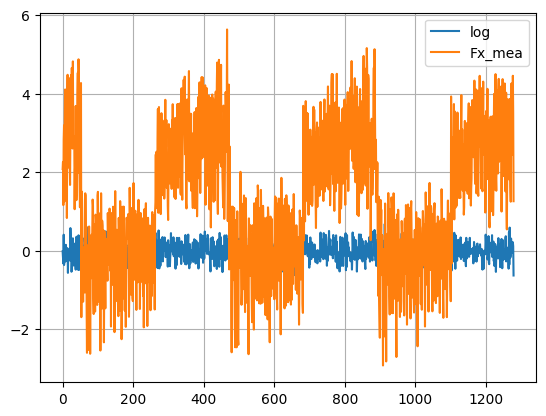

In [15]:
X = df_log.index
Y = df_log["Fx"]

# X2 = df.index
# Y2 = df["Force X"]

plt.plot(X, Y, label="log")
# plt.plot(X2,Y2)

plt.grid()
plt.plot(X, df_log["Fx_Mea"], label="Fx_mea")
plt.legend()

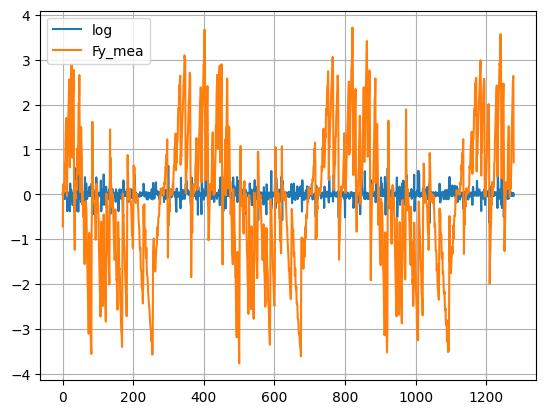

In [16]:
X = df_log.index
Y = df_log["Fy"]

# X2 = df.index
# Y2 = df["Force X"]

plt.plot(X, Y, label="log")
# plt.plot(X2,Y2)

plt.grid()
plt.plot(X, df_log["Fy_Mea"], label="Fy_mea")
plt.legend()